# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

<IPython.core.display.Javascript object>

Num GPUs Available:  0


## Indest Data

In [3]:
df = pd.read_csv("Frozen_Dessert_Production.csv",index_col='DATE', parse_dates = True)

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [6]:
df.columns=["Production"]

In [7]:
df.describe()

,Production
count,573.000
mean,109.896
std,27.951
min,58.660
25%,88.936
50%,107.643
75%,128.278
max,196.174


<AxesSubplot:xlabel='DATE'>

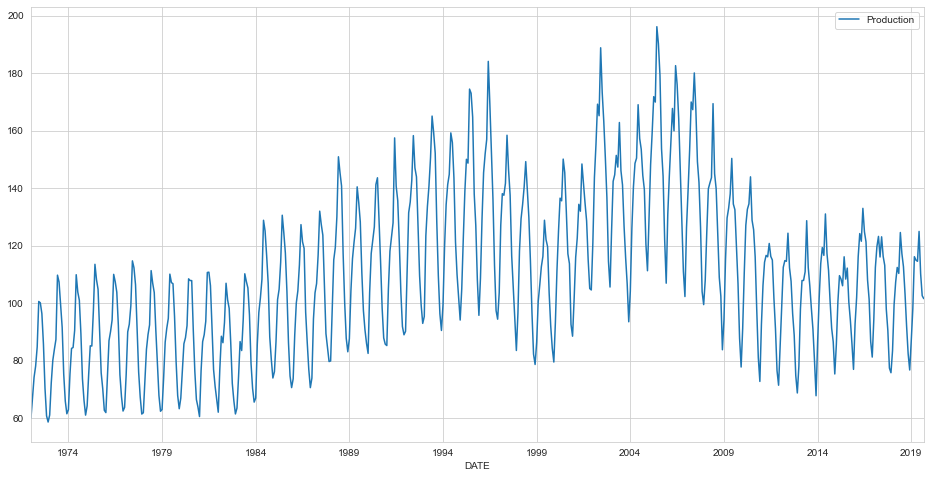

In [8]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [9]:
len(df)

573

In [10]:
test_size = 24

test_ind = len(df) - test_size
test_ind

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]


In [11]:
train.tail()

,Production
DATE,
2017-05-01,116.064
2017-06-01,123.087
2017-07-01,116.264
2017-08-01,113.172
2017-09-01,97.912


In [12]:
test

,Production
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


### Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [14]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, 
                                length=length, 
                                batch_size=batch_size)
len(generator)

537

## Modelling & Model Performance

### Import related libraries

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [18]:
n_features = train_scaled.shape[1]
n_features

1

### Creating Model

### with "tanh" activation function

In [19]:
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True,
          input_shape=(length, n_features)))
model.add(LSTM(50, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights= True)

In [22]:
validation_generator = TimeseriesGenerator(
    test_scaled, test_scaled, length=length, batch_size=batch_size)

In [23]:
result = model.fit_generator(generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
537/537 [==============================] - 10s 13ms/step - loss: 0.0206 - val_loss: 0.0035
Epoch 2/20
537/537 [==============================] - 7s 12ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 3/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 4/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 5/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 6/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 7/20
537/537 [==============================] - 7s 12ms/step - loss: 0.0032 - val_loss: 0.0055


<AxesSubplot:>

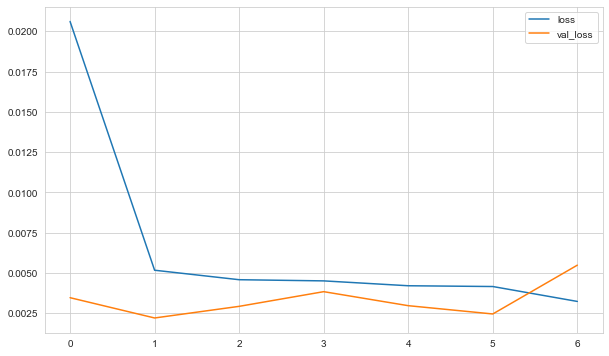

In [24]:
loss_df = pd.DataFrame(result.history)
loss_df.plot()

#### Evaluate on Test Data

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [26]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):

    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)

    # store prediction
    predictions_scaled.append(current_pred[0])

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)


In [27]:
predictions_scaled

[array([0.2584978], dtype=float32),
 array([0.22822092], dtype=float32),
 array([0.25421837], dtype=float32),
 array([0.31745028], dtype=float32),
 array([0.38297376], dtype=float32),
 array([0.4340109], dtype=float32),
 array([0.47351554], dtype=float32),
 array([0.49282593], dtype=float32),
 array([0.49646366], dtype=float32),
 array([0.45456633], dtype=float32),
 array([0.3922696], dtype=float32),
 array([0.3185283], dtype=float32)]

In [28]:

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:", mse, "\nrmse:", rmse)

eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.4639579279794137 
mae: 0.06697829379245034 
mse: 0.006684787058358447 
rmse: 0.08176054707717192


#### Inverse Transformations and Comparing

In [29]:
predictions = scaler.inverse_transform(predictions_scaled)

compare = test[:12]

compare['Predictions'] = predictions

compare


,Production,Predictions
DATE,,
2017-10-01,90.473,94.207
2017-11-01,77.438,90.043
2017-12-01,75.812,93.618
2018-01-01,83.434,102.314
2018-02-01,99.490,111.324
2018-03-01,107.315,118.342
2018-04-01,112.431,123.775
2018-05-01,110.354,126.430
2018-06-01,124.584,126.930


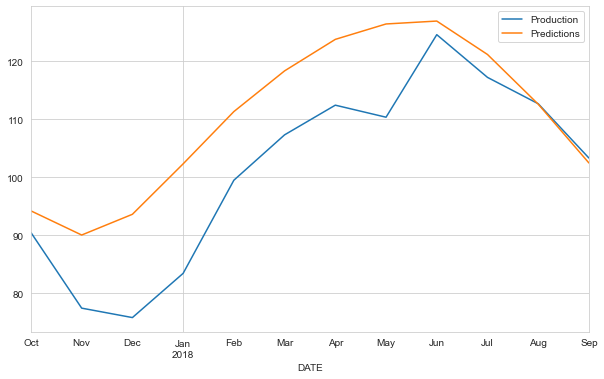

In [30]:

compare.plot();

#### Calculation R2 Score and Error Metrics

In [31]:

eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.4639579279794146 
mae: 9.210446394745627 
mse: 126.4098092121875 
rmse: 11.243211694715505


### with "relu" activation function

In [32]:
model2 = Sequential()
model2.add(LSTM(100, activation='relu', return_sequences=True,
          input_shape=(length, n_features)))
model2.add(LSTM(50, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

In [33]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [34]:
result2 = model2.fit_generator(generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
537/537 [==============================] - 7s 10ms/step - loss: 0.0291 - val_loss: 0.0069
Epoch 2/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0118 - val_loss: 0.0027
Epoch 3/20
537/537 [==============================] - 6s 10ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 4/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 5/20
537/537 [==============================] - 6s 10ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 6/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 7/20
537/537 [==============================] - 6s 10ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 8/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 9/20
537/537 [==============================] - 6s 10ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 10/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0040 - val_lo

<AxesSubplot:>

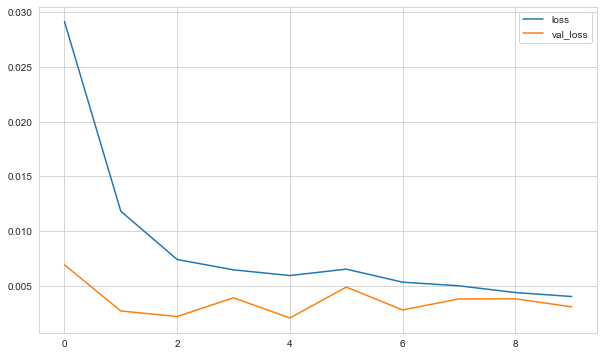

In [35]:
loss2_df = pd.DataFrame(result2.history)
loss2_df.plot()

#### Evaluate on Test Data

In [36]:
predictions_scaled2 = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):

    # get prediction 1 time stamp ahead
    current_pred = model2.predict(current_batch)

    # store prediction
    predictions_scaled2.append(current_pred[0])

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [37]:
eval_metrics(test_scaled[:length], predictions_scaled2)

r2_score: 0.7840229757467044 
mae: 0.04477484696110237 
mse: 0.0026933714571862042 
rmse: 0.05189770184879292


#### Inverse Transformations and Comparing

In [38]:
predictions2 = scaler.inverse_transform(predictions_scaled2)

compare['Predictions2'] = predictions2

compare

,Production,Predictions,Predictions2
DATE,,,
2017-10-01,90.473,94.207,96.440
2017-11-01,77.438,90.043,81.815
2017-12-01,75.812,93.618,80.978
2018-01-01,83.434,102.314,94.963
2018-02-01,99.490,111.324,109.427
2018-03-01,107.315,118.342,117.315
2018-04-01,112.431,123.775,119.582
2018-05-01,110.354,126.430,119.897
2018-06-01,124.584,126.930,122.487


<AxesSubplot:xlabel='DATE'>

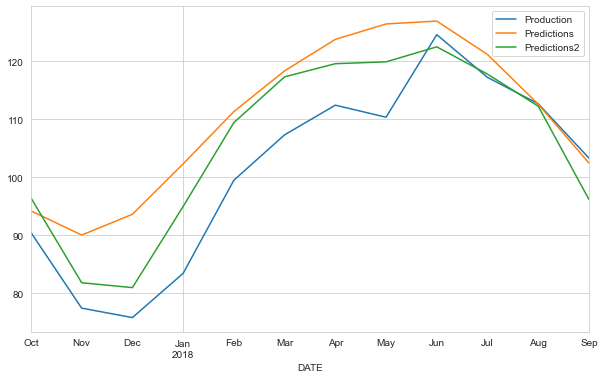

In [39]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [40]:
eval_metrics(compare.Production, compare.Predictions2)

r2_score: 0.7840229757467048 
mae: 6.1571638275243314 
mse: 50.93185004520799 
rmse: 7.13665538226472


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [41]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)


In [42]:
generator = TimeseriesGenerator(
    scaled_full_data, scaled_full_data, length=length, batch_size=batch_size)

len(df), len(generator)

(573, 561)

In [43]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True,
          input_shape=(length, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=15)


Epoch 1/15
561/561 [==============================] - 7s 9ms/step - loss: 0.0260
Epoch 2/15
561/561 [==============================] - 5s 9ms/step - loss: 0.0103
Epoch 3/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0079
Epoch 4/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0063
Epoch 5/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0054
Epoch 6/15
561/561 [==============================] - 6s 11ms/step - loss: 0.0059
Epoch 7/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0057
Epoch 8/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0056
Epoch 9/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0047
Epoch 10/15
561/561 [==============================] - 5s 10ms/step - loss: 0.0043
Epoch 11/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0041
Epoch 12/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0039
Epoch 13/15
561

In [44]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)

    # store prediction
    forecast.append(current_pred[0])

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)


In [45]:
df.tail()


,Production
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [46]:
forecast_index = pd.date_range(start='2019-10-01', periods=length, freq='MS')
forecast_index


DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [47]:
forecast = scaler.inverse_transform(forecast)

forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Production'])
forecast_df 

,Production
2019-10-01,92.163
2019-11-01,84.333
2019-12-01,82.695
2020-01-01,91.792
2020-02-01,104.676
2020-03-01,116.827
2020-04-01,124.362
2020-05-01,130.833
2020-06-01,133.622
2020-07-01,128.296


In [48]:
df_extend = df.append(forecast_df.iloc[0])


<AxesSubplot:xlabel='DATE'>

<Figure size 1152x576 with 0 Axes>

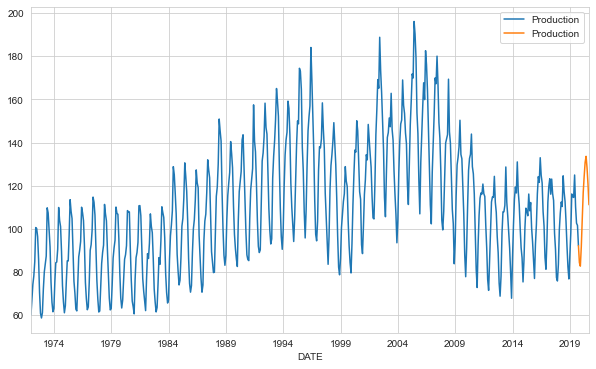

In [49]:
plt.figure(figsize=(16, 8))
ax = df_extend.plot()
forecast_df.plot(ax=ax)


(524.0, 608.0)

<Figure size 1152x576 with 0 Axes>

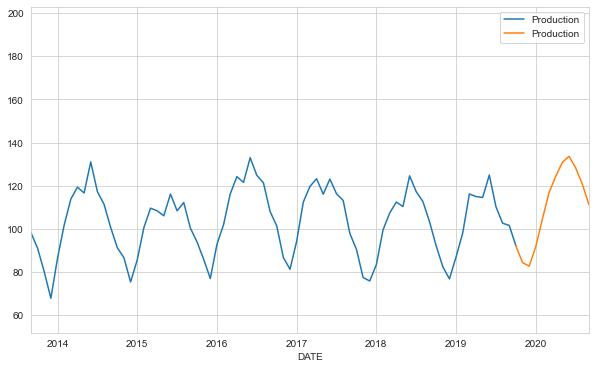

In [50]:
plt.figure(figsize=(16, 8))
ax = df_extend.plot()
forecast_df.plot(ax=ax)
plt.xlim("2013-09-01", '2020-09-01')